<a href="https://colab.research.google.com/github/kitarp07/Facial-Recognition/blob/master/facial_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!pip install rarfile



In [ ]:
import rarfile
# Replace 'aug_images.zip' with the actual name of your zip file
with rarfile.RarFile('/content/drive/MyDrive/data.rar', 'r') as rar_ref:
    rar_ref.extractall()

In [ ]:
# !tar xf lfw.tgz

In [ ]:
# for file in os.listdir(os.path.join('C:/Users/DELL/Pictures/Camera Roll/', 'positives')):
#     img_filename = file
#     img = cv2.imread(os.path.join('C:/Users/DELL/Pictures/Camera Roll/positives', img_filename))
#     newpath = os.path.join('data', 'positives', img_filename)
#     rescaled_img =  img[200:200+250, 250:250+250, :]
#     cv2.imwrite(newpath, rescaled_img)



In [ ]:
# for directory in os.listdir('lfw'):
#     for file in os.listdir(os.path.join('lfw', directory)):
#         ex_path = os.path.join('lfw', directory, file)
#         new_path = os.path.join('data', 'negatives', file)
#         os.replace(ex_path, new_path)

In [ ]:
anchor = tf.data.Dataset.list_files('/content/data/anchor/*.jpg')
positive = tf.data.Dataset.list_files('/content/data/positives/*.jpg')
negative = tf.data.Dataset.list_files('/content/data/negatives/*.jpg')


In [ ]:
def preprocess_img(file):
    # read img and store it as byte string
    byte_img = tf.io.read_file(file)
    #convert to tensor representing image
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100, 100))
    img = img/ 255.0
    return img

In [ ]:
# creats 1s and 0s labeL
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [ ]:
samples = data.as_numpy_iterator()

In [ ]:
b= samples.next()

In [ ]:
# preprocess zipped data
def preprocess_zipped(anchor, validation ,label):
    return(preprocess_img(anchor), preprocess_img(validation), label)



In [ ]:
prep_data = data.map(preprocess_zipped)

In [ ]:

df = prep_data.cache()
df = df.shuffle(buffer_size=1024)

In [ ]:
df

<_ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [ ]:
samples = df.as_numpy_iterator()

In [ ]:
samples.next()[2]

0.0

In [ ]:
round(len(df) * 1), round(len(df) * 0.7), 408-286

(408, 286, 122)

In [ ]:
train_data = df.take(286)
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [ ]:
test_data = df.skip(286)
test_data = test_data.take(122)
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [ ]:
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [ ]:
def make_embedding():

  inputt = tf.keras.layers.Input(shape=(100,100,3))

  conv_1 = tf.keras.layers.Conv2D(64, (10,10), activation='relu')(inputt)

  pool_1 = tf.keras.layers.MaxPooling2D(64, (2,2), padding='same')(conv_1)

  conv_2 = tf.keras.layers.Conv2D(128, (7,7), activation='relu')(pool_1)

  pool_2 = tf.keras.layers.MaxPooling2D(64, (2,2), padding='same')(conv_2)

  conv_3 = tf.keras.layers.Conv2D(128, (4,4), activation='relu')(pool_2)

  pool_3 = tf.keras.layers.MaxPooling2D(64, (2,2), padding='same')(conv_3)

  conv_4 = tf.keras.layers.Conv2D(256, (4,4), activation='relu')(pool_3)

  flattened = tf.keras.layers.Flatten()(conv_4)

  dense_1 = tf.keras.layers.Dense(4096, activation='sigmoid')(flattened)



  return tf.keras.models.Model(inputs=[inputt], outputs=[dense_1], name='embedding')

In [ ]:
embedding = make_embedding()

In [ ]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [ ]:
class L1Dist(tf.keras.layers.Layer):
      def __init__(self, **kwargs):
          super().__init__()

      def call(self, input_embedding, validation_embedding):
          return tf.math.abs(input_embedding - validation_embedding)

In [ ]:
l1 = L1Dist()

In [ ]:
def make_siamese_model():

  anchor_image = tf.keras.layers.Input(shape=(100, 100, 3))

  val_image = tf.keras.layers.Input(shape=(100, 100, 3))

  siamese_layer = L1Dist()

  distances = siamese_layer(embedding(anchor_image), embedding(val_image))

  classifier = tf.keras.layers.Dense(1, activation = "sigmoid")(distances)

  return tf.keras.models.Model(inputs=[anchor_image, val_image], outputs=classifier, name="SiameseModel")





In [ ]:
class SiameseModel(tf.keras.models.Model):
  def __init__(self, siamese_model, **kwargs):
    super().__init__(**kwargs)
    self.model = siamese_model

  def compile(self, opt, class_loss,  **kwargs):
        super().compile(**kwargs)
        self.c_loss = class_loss

        self.opt = opt

  def train_step(self, batch, **kwargs):

    with tf.GradientTape() as tape:
      x = batch[:2]
      y = batch[2]

      y_pred = self.model(x, training = True)

      loss = self.c_loss(y, y_pred)


    grad = tape.gradient(loss, self.model.trainable_variables)

    opt.apply_gradients(zip(grad, self.model.trainable_variables))

    return {"loss": loss}

  def test_step(self, batch, **kwargs):
     x = batch[:2]
     y = batch[2]

     y_pred = self.model(x, training = False)

     loss = self.c_loss(y, y_pred)

     return {"loss": loss}

  def call(self,x, **kwargs):
    return self.model(x, **kwargs)









In [ ]:
siamese_model = make_siamese_model()

In [ ]:
siamese_model.summary()

Model: "SiameseModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_2[0][0]',                
                                                                  'input_3[0][0]']     

In [ ]:
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [ ]:
opt = tf.keras.optimizers.Adam(1e-4)

In [ ]:
# checkpoint_dir = '/content/drive/MyDrive/training_checkpoint'
# checkpoint_prefix = os.path.join(checkpoint_dir,  'ckpt')
# checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [ ]:
@tf.function
def train_step(batch):

    with tf.GradientTape() as tape:
      x = batch[:2]
      y = batch[2]

      y_pred = siamese_model(x, training = True)

      loss = binary_cross_entropy(y, y_pred)


    grad = tape.gradient(loss, siamese_model.trainable_variables)

    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss



In [ ]:
def train(data, epochss):
    for i in range(1, epochss+1):
        print('\n Epoch {}/{}'.format(i, epochss))

        progbar = tf.keras.utils.Progbar(len(data))

        for idx, batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+1)




In [ ]:
train(train_data, 50)


 Epoch 1/50
18/18 [==============================] - 17s 251ms/step

 Epoch 2/50
18/18 [==============================] - 3s 181ms/step

 Epoch 3/50
18/18 [==============================] - 3s 181ms/step

 Epoch 4/50
18/18 [==============================] - 3s 182ms/step

 Epoch 5/50
18/18 [==============================] - 3s 183ms/step

 Epoch 6/50
18/18 [==============================] - 3s 183ms/step

 Epoch 7/50
18/18 [==============================] - 3s 184ms/step

 Epoch 8/50
18/18 [==============================] - 3s 184ms/step

 Epoch 9/50
18/18 [==============================] - 3s 184ms/step

 Epoch 10/50
18/18 [==============================] - 3s 184ms/step

 Epoch 11/50
18/18 [==============================] - 3s 185ms/step

 Epoch 12/50
18/18 [==============================] - 3s 186ms/step

 Epoch 13/50
18/18 [==============================] - 3s 186ms/step

 Epoch 14/50
18/18 [==============================] - 3s 186ms/step

 Epoch 15/50
18/18 [=====================

In [ ]:
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [ ]:
y_pred = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 26ms/step


In [ ]:
y_pred

array([[3.6419567e-10],
       [1.0000000e+00],
       [1.6222147e-07],
       [1.0000000e+00],
       [4.3734021e-06],
       [1.0503346e-05],
       [1.4488492e-05],
       [9.9998617e-01],
       [9.9999964e-01],
       [9.9999964e-01],
       [1.0000000e+00],
       [7.4420717e-07],
       [1.0000000e+00],
       [9.9990296e-01],
       [1.5734327e-09],
       [2.2577236e-09]], dtype=float32)

In [ ]:
[1 if prediction >0.5 else 0 for prediction in y_pred]

[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0]

In [ ]:
res = Recall()

p = Precision ()
res.update_state(y_true, y_pred)
p.update_state(y_true, y_pred)

res.result().numpy(), p.result().numpy()

(1.0, 1.0)

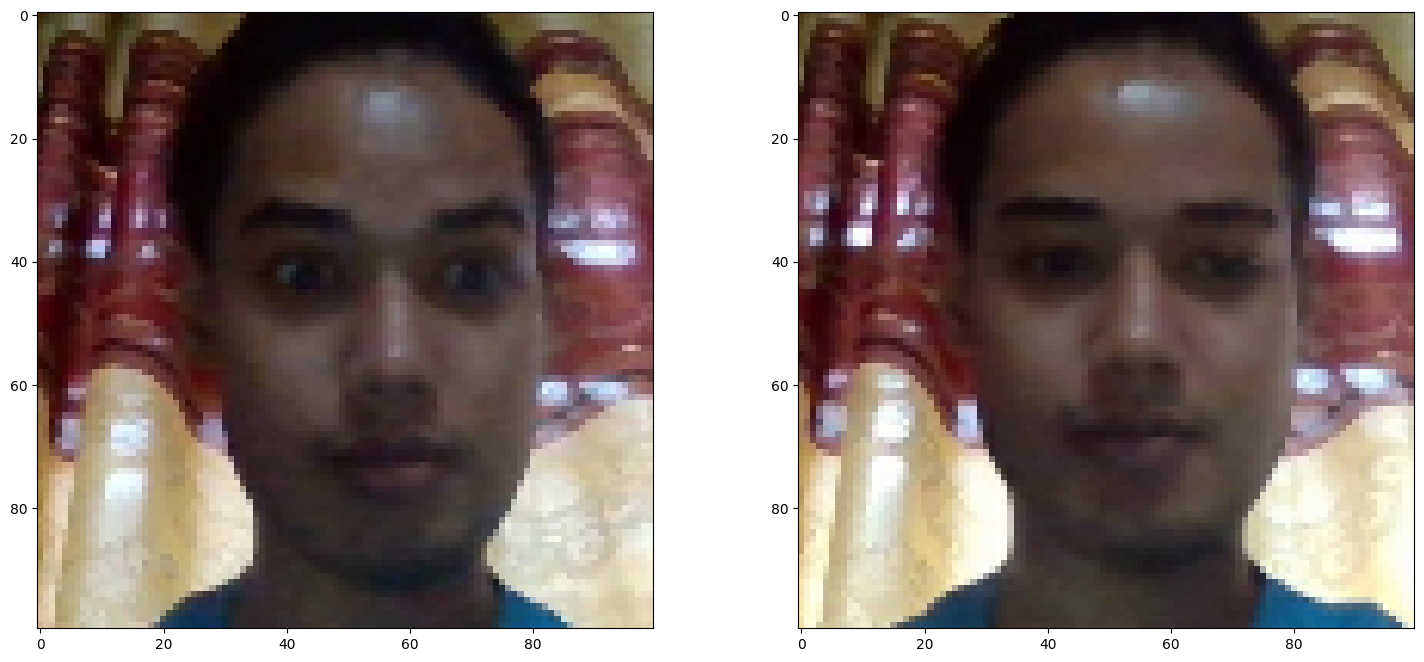

In [ ]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.imshow(test_input[3])
plt.subplot(1,2,2)
plt.imshow(test_val[3])
plt.show()

In [ ]:
siamese_model.save('siamese_model.h5')

In [ ]:
load_model = tf.keras.models.load_model('siamese_model.h5', custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy': tf.keras.losses.BinaryCrossentropy})

In [ ]:
l = load_model.predict([test_input, test_val])

1/1 [==============================] - 0s 31ms/step


In [ ]:
[1 if prediction >0.5 else 0 for prediction in l]

[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0]

In [ ]:
model_2 = make_siamese_model()

In [ ]:
model_2.summary()

Model: "SiameseModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_2[0][0]',                
                                                                  'input_3[0][0]']     

In [ ]:
model_2_via_class = SiameseModel(model_2)


In [ ]:
model_2_via_class.compile(opt, binary_cross_entropy)

In [ ]:
history = model_2_via_class.fit(train_data, epochs=50)

Epoch 1/50
18/18 [==============================] - 18s 243ms/step - loss: 0.5936
Epoch 2/50
18/18 [==============================] - 4s 204ms/step - loss: 0.2349
Epoch 3/50
18/18 [==============================] - 4s 203ms/step - loss: 0.0396
Epoch 4/50
18/18 [==============================] - 4s 204ms/step - loss: 0.0037
Epoch 5/50
18/18 [==============================] - 4s 207ms/step - loss: 5.8916e-04
Epoch 6/50
18/18 [==============================] - 4s 206ms/step - loss: 3.8848e-04
Epoch 7/50
18/18 [==============================] - 4s 207ms/step - loss: 2.2176e-04
Epoch 8/50
18/18 [==============================] - 4s 208ms/step - loss: 1.3254e-04
Epoch 9/50
18/18 [==============================] - 4s 207ms/step - loss: 1.2299e-04
Epoch 10/50
18/18 [==============================] - 4s 206ms/step - loss: 1.0334e-04
Epoch 11/50
18/18 [==============================] - 4s 207ms/step - loss: 8.8975e-05
Epoch 12/50
18/18 [==============================] - 4s 205ms/step - loss: 7.3

In [ ]:
model_2_via_class.evaluate(test_data)

8/8 [==============================] - 1s 130ms/step - loss: 2.2078e-06


3.4809702356142225e-06